# Train Booking prediction predictor

The Tweedie distribution [2] is a special case of exponential dispersion models
and is often used as a distribution for generalized linear models. If data has a
large amount of zeroes, and only positive values otherwise, it is a good place to
start. Another option would be to use a Zero Inflated Poisson Regression Model
[3], but we opt for a Tweedie model due to ease of implementation.
Tweedie regression has been successfully applied on insurance claim data,
which is a typical example of zero-inflated data [4].
We propose to use gradient boosted trees to attempt a solution. Boosting
is an ensemble learning method, where new models are added to the current
model until there are no more improvements [1]. We choose to use the python
package XGBoost ([5]) with tweedie regression option.

[1] Maurice CK Tweedie. An index which distinguishes between some important
exponential families. In Statistics: Applications and new directions: Proc.
Indian statistical institute golden Jubilee International conference, volume
579, pages 579{604, 1984.

[2] Alexander Noll, Robert Salzmann, and Mario V Wuthrich. Case study:
French motor third-party liability claims. Available at SSRN 3164764, 2020.

[3] Jerome H. Friedman. Greedy function approximation: A gradient boosting
machine. Annals of Statistics, 29:1189{1232, 2000.

[4] Tianqi Chen and Carlos Guestrin. XGBoost: A scalable tree boosting sys-
tem. In Proceedings of the 22nd ACM SIGKDD International Conference
on Knowledge Discovery and Data Mining, KDD '16, pages 785{794, New
York, NY, USA, 2016. ACM.


### Train tweedie predicotor with RMSLE loss over 5 cross-validation folds

We use Root Mean Squared Logarithmic Error (RMSLE) as a loss function
since it is appropriate when we have zero-valued data; use of RMSE can result
in numerical instabilities.


In [1]:
plot_folder = '/home/mattias/Documents/project/BookingPrediction/plots/'
dataset_pickle_folder = '/home/mattias/Documents/project/BookingPrediction/datasetPickles/'
trained_predictor_folder = '/home/mattias/Documents/project/BookingPrediction/trainedPredictor/'

In [2]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
import pandas as pd
import numpy as np
import pickle

### Load processed dataset that is the end result of our EDA in EDA_preprocessing_BookingPrediction.ipynb

In [3]:
X_train = pd.read_pickle(dataset_pickle_folder + 'postEDA_train_predictors.pkl')
X_test = pd.read_pickle(dataset_pickle_folder + 'postEDA_independ_test_predictors.pkl')
y_train = pd.read_pickle(dataset_pickle_folder + 'train_response.pkl')
y_test = pd.read_pickle(dataset_pickle_folder + 'independ_test_response.pkl')

### Train tweedie predicotor with RMSLE loss over 5 cross-validation folds.  

In [4]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [5]:
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

In [6]:
num_boost_round = 100

### Parameters
We use a single setting for parameters, most importantly 100 estimators and
max depth=11. These could be refined at a later stage using a grid search with
cross-validation.
The variance power parameter for Tweedie is set at default (= 1:5), but
this is a good candidate for cross-validation since it controls the shape of the
underlying fitted distribution.

In [7]:
params = {"objective":"reg:tweedie",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 11, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=num_boost_round,early_stopping_rounds=10,metrics="rmsle", 
                    as_pandas=True, seed=123)

In [8]:
print('The cross-validation mean of RMSLE (over the 5 folds) is {}'.format(cv_results['test-rmsle-mean'].iloc[-1]))

The cross-validation mean of RMSLE (over the 5 folds) is 0.26449639999999996


This value is not in itself very meaningful, since
RMSLE does not have a very intuitive interpretation. It is however important if
we want to compare different models. The important point here is that RMSLE
will allow us to deal with zero-inflated data in training.

### Train predictor with RMSLE loss 

In [9]:
xg_reg = xgb.XGBRegressor(objective ='reg:tweedie', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 11, alpha = 10, n_estimators = num_boost_round)

In [10]:
xg_reg.fit(X_train,y_train,eval_metric='rmsle')

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=11,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:tweedie', random_state=0, reg_alpha=10,
             reg_lambda=1, scale_pos_weight=None, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Plot feature importance
Top features are in our boosted tree model:
1. num reviews times star
2. number of rooms
3. dayofmonth
4. search day distance
5. search nights

It seems that our engineered features (num reviews times star and dayofmonth)
are very important to our predictor.

Interestingly device TABLET does come next in line albeit much lower. This
illustrates that weak features can indeed be useful when building predictors with
XGBOOST.

<Figure size 360x720 with 0 Axes>

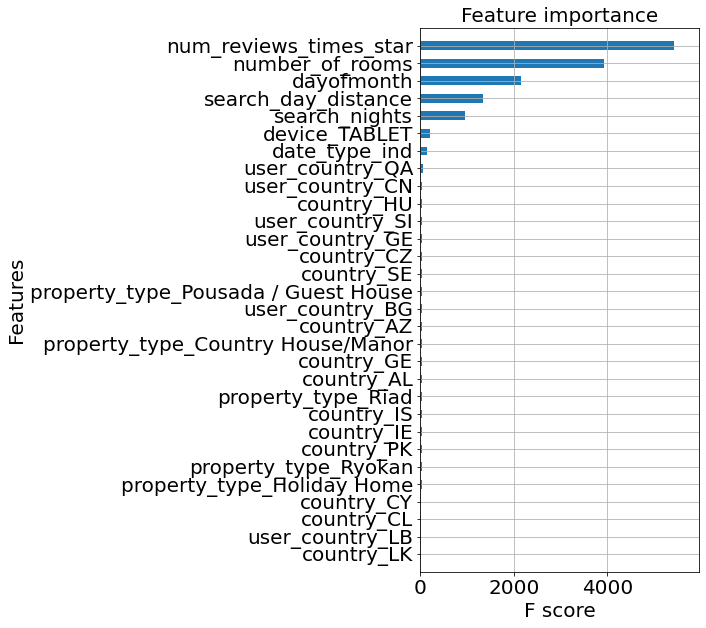

In [24]:
# plot feature importance
import matplotlib.pyplot as plt 
from xgboost import plot_importance
plt.figure(figsize=(5,10))
plot_importance(xg_reg,max_num_features= 30,show_values=False, height =0.5)
plt.rcParams["figure.figsize"] = (5,10)
plt.ylabel('Features',fontsize=20)
plt.xlabel('F score',fontsize=20)
plt.title('Feature importance',fontsize=20)
plt.tick_params(labelsize=20)
#plt.tight_layout()
plt.savefig(plot_folder + 'feature_importance.png', dpi=300)

### Test predictor on independent test data set with evaluation measure RMSE and MAE.
We use RMSE (Root mean square error) and MAE (Mean Absolute Errors)
for evaluation metrics since these are more easily interpretable than RMSLE.
When RMSE in normalized w.r.t range of data, it gives the prediction errors as
a percentage of the range of data. Since absolute error is the absolute value of
the difference between the predicted value and the actual value, MAE is easily
interpretable.

We test our trained predictor on our independent test set. The normalized
RMSE is 0.02 which means the prediction errors are 2% of the range of the
data. The mean absolute error is 0:14.

In [46]:
range_y_test = np.max(y_test)-np.min(y_test)

In [47]:
y_pred = np.round(xg_reg.predict(X_test))

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

rmse_test = sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred)

norm_test_rmse_mean = rmse_test/range_y_test
round_nrmse_test = round(float(norm_test_rmse_mean),2)

In [49]:
print('Using {} estimators, the normalized mean RMSE is {}. Thus the prediction errors are {} percent of the range of data.'.format(num_boost_round,round_nrmse_test,100*round_nrmse_test))

Using 100 estimators, the normalized mean RMSE is 0.02. Thus the prediction errors are 2.0 percent of the range of data.


In [50]:
print('Using {} estimators, the mean absolute error is {}.'.format(num_boost_round,mae_test))

Using 100 estimators, the mean absolute error is 0.1354074986798099.


## Save xgboost model to file

In [51]:
pickle.dump(xg_reg, open(trained_predictor_folder + "xgb_booking_pred.pickle.dat", "wb"))